# Practise Case Week 5: Model Deployment
#### IYKRA Data Fellowship - Data Engineer
##### By: Christopher Aldora Tjitrabudi

This notebook describe the process and analysis of the machine learning model for customer churning using Berdikari Bank dataset.


In [1]:
# Import libraries
import pandas as pd

# Machine Learning model from Scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Another class/method for analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.tree import export_graphviz

# XGBoost Classifier, better performance than sklearn
from xgboost import XGBClassifier

# Used to transform dot to png
from subprocess import call

# Display image (Random Forest model) in notebook
from IPython.display import Image

# Count running time of prediction
from time import time

# Plot running time of prediction
import matplotlib.pyplot as plt

# Pickle model to file
import dill as pickle


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Read the dataset
Churn_Modelling = pd.read_csv('..\data\Churn_Modelling.csv')
Churn_Modelling

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0          2       0.00              1          1               1   
1          1   83807.86              1          0               1   
2          8  159660.80              3          1               0   
3          1       0.00              2          0               0   
4          2  125510.82              1          1               1   
...      ...        ...            ...        ...             ...   
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
0           101348.88       1  
1           112542.58       0  
2           113931.57       1  
3            93826.63       0  
4            79084.10       0  
...               ...     ...  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0  

[10000 rows x 14 columns]

In [3]:
# THe Geography and Gender columns is not numerical, transform to categorical.
# Find the unique values and save as a dict
category = {
    "Geography": list(Churn_Modelling["Geography"].unique()),
       "Gender": list(Churn_Modelling["Gender"].unique())
}
category

{'Geography': ['France', 'Spain', 'Germany'], 'Gender': ['Female', 'Male']}

In [4]:
# Change dtypes to categorical using `category` dict
Churn_Modelling["Geography_cat"] = pd.Categorical(Churn_Modelling["Geography"], 
                                                  categories = category["Geography"], 
                                                  ordered = False)
Churn_Modelling["Geography_cat"] = Churn_Modelling["Geography_cat"].cat.codes

Churn_Modelling["Gender_cat"] = pd.Categorical(Churn_Modelling["Gender"], 
                                               categories = category["Gender"], 
                                               ordered = False)
Churn_Modelling["Gender_cat"] = Churn_Modelling["Gender_cat"].cat.codes

# The last column is the prediction we will make
# RowNumber, CustomerId, and Surname columns is not used to train the model
target = Churn_Modelling["Exited"]
dataset = Churn_Modelling.iloc[:,[3,14,15,6,7,8,9,10,11,12]]
dataset

CreditScore  Geography_cat  Gender_cat  Age  Tenure    Balance  \
0             619              0           0   42       2       0.00   
1             608              1           0   41       1   83807.86   
2             502              0           0   42       8  159660.80   
3             699              0           0   39       1       0.00   
4             850              1           0   43       2  125510.82   
...           ...            ...         ...  ...     ...        ...   
9995          771              0           1   39       5       0.00   
9996          516              0           1   35      10   57369.61   
9997          709              0           0   36       7       0.00   
9998          772              2           1   42       3   75075.31   
9999          792              0           0   28       4  130142.79   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0                 1          1               1        101348.88  
1                 1          0               1        112542.58  
2                 3          1               0        113931.57  
3                 2          0               0         93826.63  
4                 1          1               1         79084.10  
...             ...        ...             ...              ...  
9995              2          1               0         96270.64  
9996              1          1               1        101699.77  
9997              1          0               1         42085.58  
9998              2          1               0         92888.52  
9999              1          1               0         38190.78  

[10000 rows x 10 columns]

In [5]:
# Make sure all columns are ready for training
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography_cat    10000 non-null  int8   
 2   Gender_cat       10000 non-null  int8   
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), int8(2)
memory usage: 644.7 KB


In [6]:
# Split the dataset
(trainX, testX, trainY, testY) = train_test_split(dataset, target, shuffle=False)

In [7]:
# Use dict to save the model name and trained model
dict_models = {
    "knn": KNeighborsClassifier(),
    "naive_bayes": GaussianNB(),
    "logit": LogisticRegression(),
    "svm": SVC(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier()
}
dict_train_models = {}

In [8]:
# Training the models
for model_name in dict_models:
    print("-----------------------------------------------------")
    print("Using '{}' model".format(model_name))
    model = dict_models[model_name]
    train_model = model.fit(trainX, trainY)
    dict_train_models[model_name] = train_model
    
    # Print report and accuracy
    predictions = train_model.predict(testX)
    print(classification_report(testY, predictions, target_names=['0','1']))
    print("Accuracy for "+model_name+" Model: %.2f%%" % (precision_score(testY, predictions) * 100))

-----------------------------------------------------
Using 'knn' model
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      2009
           1       0.22      0.08      0.12       491

    accuracy                           0.76      2500
   macro avg       0.51      0.51      0.49      2500
weighted avg       0.69      0.76      0.72      2500

Accuracy for knn Model: 22.22%
-----------------------------------------------------
Using 'naive_bayes' model
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      2009
           1       0.37      0.09      0.15       491

    accuracy                           0.79      2500
   macro avg       0.59      0.53      0.51      2500
weighted avg       0.72      0.79      0.74      2500

Accuracy for naive_bayes Model: 36.59%
-----------------------------------------------------
Using 'logit' model
              precision    recall  f1-score   supp

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2009
           1       0.00      0.00      0.00       491

    accuracy                           0.80      2500
   macro avg       0.40      0.50      0.45      2500
weighted avg       0.65      0.80      0.72      2500

Accuracy for svm Model: 0.00%
-----------------------------------------------------
Using 'decision_tree' model
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2009
           1       0.47      0.52      0.49       491

    accuracy                           0.79      2500
   macro avg       0.67      0.69      0.68      2500
weighted avg       0.80      0.79      0.79      2500

Accuracy for decision_tree Model: 46.95%
-----------------------------------------------------
Using 'random_forest' model
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2009
  

In [9]:
# Accuracy for KNN Model           : 22.22%
# Accuracy for Naive Bayes Model   : 36.59%
# Accuracy for logistic reg Model  : 33.73%
# Accuracy for SVM Model           :  0.00% (zero_division)
# Accuracy for Decision Tree Model : 45.40%
# Accuracy for Random Forest Model : 74.41%
#
# Random Forest have highest accurary
RF_model = dict_train_models["random_forest"]
print(dict_train_models["random_forest"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [10]:
# Extract single tree
estimator = RF_model.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = dataset.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
Image(filename = 'tree.png')

In [11]:
# Use XGBoost Model
xgb_model = XGBClassifier()
xgb_train_model = xgb_model.fit(trainX, trainY)
predictions = xgb_train_model.predict(testX)
print('XGboost Model Report')
print(classification_report(testY, predictions))
print("\nAccuracy for XGBoost Model: %.2f%%" % (precision_score(testY, predictions) * 100))

XGboost Model Report
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2009
           1       0.75      0.44      0.55       491

    accuracy                           0.86      2500
   macro avg       0.81      0.70      0.73      2500
weighted avg       0.85      0.86      0.85      2500


Accuracy for XGBoost Model: 74.83%


In [12]:
# XGBoost Model is slightly better than Random Forest
# We will compare the running time of the prediction

time_start=time()
time_end=time()

time_RF=[]
time_XGB=[]

for i in range(1,10001,100):
    time_start = time()
    RF_model.predict(dataset[0:i])
    time_end = time()
    time_RF.append(time_end-time_start)
    
    time_start = time()
    xgb_train_model.predict(dataset[0:i])
    time_end = time()
    time_XGB.append(time_end-time_start)

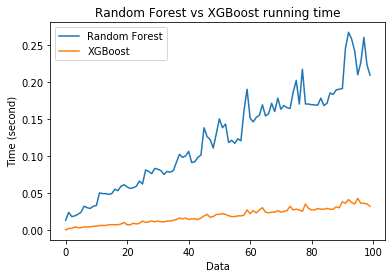

In [13]:
plt.plot(time_RF)
plt.plot(time_XGB)
plt.xlabel('Data')
plt.ylabel('Time (second)')
plt.title('Random Forest vs XGBoost running time')
plt.legend(['Random Forest','XGBoost'])
plt.show()

XGBoost model prediction is faster than Random Forest, we will use XGBoost for production as speed is an important factor for building API.

In [14]:
# Pickling, dump the model and additional information for deployment

with open('../models/model_rf.pk', 'wb') as file:
    pickle.dump(RF_model, file)

with open('../models/model_xgb.pk', 'wb') as file:
    pickle.dump(xgb_train_model, file)

with open('../models/category.pk', 'wb') as file:
    pickle.dump(category, file)
    
with open('../models/column.pk', 'wb') as file:
    pickle.dump(dataset.columns.to_list(), file)

In [15]:
# Go to the deployment (app\server.py)